# Bayesian Optimization

In [1]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
# %matplotlib inline

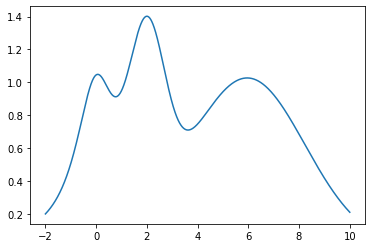

In [2]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)

In [ ]:
def plot_constrained_opt(pbounds, target_function, optimizer):
    """
    Plots a number of interesting contours to visualize constrained 2-dimensional optimization.
    """

    # Set a few parameters
    n_constraints = optimizer.constraint.lb.size
    n_plots_per_row = 2+n_constraints

    # Construct the subplot titles
    if n_constraints==1:
        c_labels = ["constraint"]
    else:
        c_labels = [f"constraint {i+1}" for i in range(n_constraints)]
    labels_top = ["target"] + c_labels + ["masked target"]
    labels_bot = ["target estimate"] + [c + " estimate" for c in c_labels] + ["acquisition function"]
    labels = [labels_top, labels_bot]

    # Setup the grid to plot on
    x = np.linspace(pbounds['x'][0], pbounds['x'][1], 1000)
    y = np.linspace(pbounds['y'][0], pbounds['y'][1], 1000)
    xy = np.array([[x_i, y_j] for y_j in y for x_i in x])
    X, Y = np.meshgrid(x, y)

    # Evaluate the actual functions on the grid
    Z = target_function(X, Y)
    # This reshaping is a bit painful admittedly, but it's a consequence of np.meshgrid
    C = optimizer.constraint.fun(X, Y).reshape((n_constraints,) + Z.shape).swapaxes(0, -1)


    fig, axs = plt.subplots(2, n_plots_per_row, constrained_layout=True, figsize=(12,8))

    for i in range(2):
        for j in range(n_plots_per_row):
            axs[i, j].set_aspect("equal")
            axs[i, j].set_title(labels[i][j])


    # Extract & unpack the optimization results
    max_ = optimizer.max
    res = optimizer.res
    x_ = np.array([r["params"]['x'] for r in res])
    y_ = np.array([r["params"]['y'] for r in res])
    c_ = np.array([r["constraint"] for r in res])
    a_ = np.array([r["allowed"] for r in res])


    Z_est = optimizer._gp.predict(xy).reshape(Z.shape)
    C_est = optimizer.constraint.approx(xy).reshape(Z.shape + (n_constraints,))
    P_allowed = optimizer.constraint.predict(xy).reshape(Z.shape)

    Acq = np.where(Z_est >0, Z_est * P_allowed, Z_est / (0.5 + P_allowed))


    target_vbounds = np.min([Z, Z_est]), np.max([Z, Z_est])
    constraint_vbounds = np.min([C, C_est]), np.max([C, C_est])


    axs[0,0].contourf(X, Y, Z, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])
    for i in range(n_constraints):
        axs[0,1+i].contourf(X, Y, C[:,:,i], cmap=plt.cm.coolwarm, vmin=constraint_vbounds[0], vmax=constraint_vbounds[1])
    Z_mask = Z

    Z_mask[~np.squeeze(optimizer.constraint.allowed(C))] = np.nan
    axs[0,n_plots_per_row-1].contourf(X, Y, Z_mask, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])

    axs[1,0].contourf(X, Y, Z_est, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])
    for i in range(n_constraints):
        axs[1,1+i].contourf(X, Y, C_est[:, :, i], cmap=plt.cm.coolwarm, vmin=constraint_vbounds[0], vmax=constraint_vbounds[1])
    axs[1,n_plots_per_row-1].contourf(X, Y, Acq, cmap=plt.cm.coolwarm, vmin=0, vmax=1)

    for i in range(2):
        for j in range(n_plots_per_row):
            axs[i,j].scatter(x_[a_], y_[a_], c='white', s=80, edgecolors='black')
            axs[i,j].scatter(x_[~a_], y_[~a_], c='red', s=80, edgecolors='black')
            axs[i,j].scatter(max_["params"]['x'], max_["params"]['y'], s=80, c='green', edgecolors='black')

    return fig, axs

## Multiple Constraints

In [10]:
import numpy as np
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from scipy.optimize import NonlinearConstraint

In [11]:
def target_function(x, y):
    # Gardner is looking for the minimum, but this packages looks for maxima, thus the sign switch
    return np.cos(2*x)*np.cos(y) + np.sin(x)

def constraint_function_2_dim(x, y):
    return np.array([
        - np.cos(x) * np.cos(y) + np.sin(x) * np.sin(y),
        - np.cos(x) * np.cos(-y) + np.sin(x) * np.sin(-y)])

pbounds = {'x': (0, 6), 'y': (0, 6)}
constraint_lower = np.array([-np.inf, -np.inf])
constraint_upper = np.array([0.6, 0.6])

In [12]:
constraint = NonlinearConstraint(constraint_function_2_dim, constraint_lower, constraint_upper)
optimizer = BayesianOptimization(
    f=target_function,
    constraint=constraint,
    pbounds=pbounds,
    verbose=1, 
    random_state=27,
)

optimizer.maximize(
    init_points=2,
    n_iter=40,
)

|   iter    |  target   |  allowed  |     x     |     y     |
-------------------------------------------------------------
| 5         | 0.9614    | True      | 2.178     | 1.983     |
| 12        | 1.941     | True      | 1.721     | 3.064     |
| 20        | 1.973     | True      | 1.495     | 2.978     |
| 22        | 1.998     | True      | 1.553     | 3.184     |
| 25        | 1.999     | True      | 1.589     | 3.135     |
| 26        | 2.0       | True      | 1.56      | 3.126     |
| 27        | 2.0       | True      | 1.569     | 3.137     |
| 29        | 2.0       | True      | 1.57      | 3.144     |
| 30        | 2.0       | True      | 1.57      | 3.144     |
| 31        | 2.0       | True      | 1.57      | 3.144     |
| 35        | 2.0       | True      | 1.572     | 3.14      |


In [13]:
plot_constrained_opt(pbounds, target_function, optimizer)

NameError: name 'plot_constrained_opt' is not defined

# Resources

* https://bayesian-optimization.github.io/BayesianOptimization/constraints.html